In [2]:
import librosa
import librosa.display
import os
import numpy as np
from torch.utils.data.dataset import random_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from joblib import dump

In [3]:
file_path = '../CMR_subset_1.0/CMRdataset.csv'

def extract_labels(file_path):
  labels = []
  with open(file_path, 'r') as f:
    # leave out the header
    next(f)
    for line in f:
      line = line.strip()
      line = line.split(',')
      labels.append(int(line[-1]))
  return labels

extracted_labels = extract_labels(file_path)

In [4]:
label_encoder = LabelEncoder()

extracted_labels = label_encoder.fit_transform(extracted_labels)
print(extracted_labels.shape)

dump(label_encoder, 'label_encoder.joblib')

(118,)


['label_encoder.joblib']

### CNN Model for Rhythmic beat classification

In [5]:
class Reshape(nn.Module):
  def __init__(self, shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.view(self.shape)

class CNN(nn.Module):
  def __init__(
    self,
    kernel_size=3,
    stride=1,
    padding=1,
    dropout=0.2,
    learning_rate=0.001,
    batch_size=64,
    num_epochs=5
  ):
    super(CNN, self).__init__()
    
    self.conv1 = nn.Conv2d(
      in_channels=1, 
      out_channels=16, 
      kernel_size=kernel_size, 
      stride=stride,
      padding=padding
    )
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    self.conv2 = nn.Conv2d(
      in_channels=16, 
      out_channels=32,
      kernel_size=kernel_size,
      stride=stride,
      padding=padding
    )
    
    self.dim1 = 10
    self.dim2 = 30
    
    self.adjust_shape = Reshape((-1, 32*self.dim1*self.dim2))
    
    self.dropout = nn.Dropout(p=dropout)
    self.fc = nn.Linear(32*self.dim1*self.dim2, 4)
    self.softmax = nn.Softmax(dim=1)
    
    self.layers = [
      self.conv1,         
      self.pool,          
      self.relu,          
      self.conv2,         
      self.pool,          
      self.relu,          
      self.dropout,       
      self.adjust_shape,  
      self.fc,            
      self.softmax        
    ]
    
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
    self.num_epochs = num_epochs
    self.batch_size = batch_size

  def forward(self, x):
    x = self.conv1(x)
    x = self.pool(x)
    x = self.relu(x)
    
    x = self.conv2(x)
    x = self.pool(x)
    x = self.relu(x)
    
    x = self.dropout(x)
    x = self.adjust_shape(x)
    x = self.fc(x)
    x = self.softmax(x)
    return x
  
  def train_model(self, train_dataset, val_dataset):
    train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True)
    
    train_loss, val_loss, accuracy, val_accuracy = 0,0,0,0
    
    for epoch in range(self.num_epochs):
      self.train()
      train_loss = 0.0
      correct = 0
      total = 0
      
      val_loss = 0.0
      val_correct = 0
      val_total = 0
      
      for inputs, labels in train_loader:
        self.optimizer.zero_grad()
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        loss.backward(retain_graph=True)
        self.optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

      self.eval()
      for inputs, labels in val_loader:
        self.optimizer.zero_grad()
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        loss.backward(retain_graph=True)
        self.optimizer.step()

        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

      val_accuracy = val_correct / val_total
      accuracy = correct / total

      print(
        f'Epoch {epoch+1}/{self.num_epochs}, '
        f'Loss(Train): {train_loss:.4f}, '
        f'Accuracy(Train): {accuracy:.2f}, '
        f'Loss(Val): {val_loss:.4f}, '
        f'Accuracy(Val): {val_accuracy:.2f}'
      )
    return train_loss, val_loss, accuracy, val_accuracy
  
  def predict(self, pred_dataset):
    pred_loader = DataLoader(pred_dataset, batch_size=self.batch_size, shuffle=False)
    self.eval()
    predictions = []
    labels_true = []
    for inputs, labels in pred_loader:
      outputs = self(inputs)
      _, predicted = torch.max(outputs.data, 1)
      predictions.extend(predicted.tolist())
      labels_true.extend(labels.numpy())
    return predictions, labels_true

In [6]:
import librosa
import os
import numpy as np

def extract_features(file_repo, duration_per_step=0.1, n_fft=1024, n_mfcc=13, hop_length=512):
  amplitudes = []
  magnitude_spectrograms = []
  mfcc_features = []
  chroma_features = []

  for audio_file in os.listdir(file_repo):
    if not audio_file.endswith('.wav'):
      continue

    # Create the full path to the audio file
    full_path = os.path.join(file_repo, audio_file)

    # Load audio file
    y, sr = librosa.load(full_path)

    # Calculate the number of steps based on the desired duration
    num_steps = int(len(y) / sr / duration_per_step)
    if num_steps < 1200:
      # padding to make sure all the files have the same length
      y = np.pad(y, (0, 1200 * sr - len(y)), 'constant')
      num_steps = 1200

    # Iterate over the steps and extract features
    for step in range(num_steps):
      start = int(step * sr * duration_per_step)
      end = int((step + 1) * sr * duration_per_step)

      # Ensure that the end index does not exceed the length of the audio signal
      end = min(end, len(y))

      interval_data = y[start:end]

      # Amplitude (Time-domain representation)
      amplitude = np.mean(interval_data)
      amplitudes.append(amplitude)

      # Frequency (Frequency-domain representation - Magnitude Spectrogram)
      magnitude_spectrogram = np.mean(np.abs(librosa.stft(interval_data, n_fft=n_fft)))
      magnitude_spectrograms.append(magnitude_spectrogram)

      # MFCC features
      mfccf = librosa.feature.mfcc(y=interval_data, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
      mfcc_features.append(mfccf)

      # Chroma features
      chromaf = librosa.feature.chroma_stft(y=interval_data, sr=sr, hop_length=hop_length, n_fft=n_fft)
      chroma_features.append(chromaf)

  return amplitudes, magnitude_spectrograms, mfcc_features, chroma_features

# Example usage
file_repo = '../CMR_subset_1.0/audio'
amps, mags, mfccs, chromas = extract_features(file_repo, duration_per_step=0.1, n_fft=1024)

/Users/chnaveen/Library/Python/3.9/lib/python/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

mfccs_new = np.array(mfccs).reshape(141600, 13*5)
chromas_new = np.array(chromas).reshape(141600, 12*5)

mfccs_new = np.mean(mfccs_new, axis=1)
chromas_new = np.mean(chromas_new, axis=1)

print(mfccs_new.shape)
print(chromas_new.shape)

amps_mags = np.hstack((amps, mags, mfccs_new, chromas_new))
amps_mags = amps_mags.reshape(118, -1)
print(amps_mags.shape)

(141600,)
(141600,)
(118, 4800)


In [8]:
X_amp_mag_train, X_amp_mag_test, y_amp_mag_train, y_amp_mag_test = train_test_split(amps_mags, extracted_labels, test_size=0.3, random_state=42)
X_amp_mag_test, X_amp_mag_val, y_amp_mag_test, y_amp_mag_val = train_test_split(X_amp_mag_test, y_amp_mag_test, test_size=0.5, random_state=42)

dt_amp_mag_classifier = DecisionTreeClassifier()

dt_amp_mag_classifier.fit(X_amp_mag_train, y_amp_mag_train)
print()

y_amp_mag_pred = dt_amp_mag_classifier.predict(X_amp_mag_val)
print(accuracy_score(y_amp_mag_val, y_amp_mag_pred))
print(label_encoder.inverse_transform(y_amp_mag_pred))
print(label_encoder.inverse_transform(y_amp_mag_val))

y_amp_mag_pred = dt_amp_mag_classifier.predict(X_amp_mag_test)
print(accuracy_score(y_amp_mag_test, y_amp_mag_pred))
print(label_encoder.inverse_transform(y_amp_mag_pred))
print(label_encoder.inverse_transform(y_amp_mag_test))


1.0
[3 5 8 7 7 8 3 8 5 8 7 7 3 8 8 3 5 5]
[3 5 8 7 7 8 3 8 5 8 7 7 3 8 8 3 5 5]
0.9444444444444444
[5 5 3 8 3 3 3 3 7 8 5 5 8 7 7 8 3 5]
[5 7 3 8 3 3 3 3 7 8 5 5 8 7 7 8 3 5]


In [9]:
from joblib import dump

dump(dt_amp_mag_classifier, 'dt_amp_mag_classifier.joblib')

['dt_amp_mag_classifier.joblib']

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf_amp_mag_classifier = RandomForestClassifier()

rf_amp_mag_classifier.fit(X_amp_mag_train, y_amp_mag_train)
print()

y_amp_mag_pred = rf_amp_mag_classifier.predict(X_amp_mag_val)
print(accuracy_score(y_amp_mag_val, y_amp_mag_pred))
print(label_encoder.inverse_transform(y_amp_mag_pred))
print(label_encoder.inverse_transform(y_amp_mag_val))

y_amp_mag_pred = rf_amp_mag_classifier.predict(X_amp_mag_test)
print(accuracy_score(y_amp_mag_test, y_amp_mag_pred))
print(label_encoder.inverse_transform(y_amp_mag_pred))
print(label_encoder.inverse_transform(y_amp_mag_test))

dump(rf_amp_mag_classifier, 'rf_amp_mag_classifier.joblib')


1.0
[3 5 8 7 7 8 3 8 5 8 7 7 3 8 8 3 5 5]
[3 5 8 7 7 8 3 8 5 8 7 7 3 8 8 3 5 5]
0.8888888888888888
[5 5 3 8 3 3 5 3 7 8 5 5 8 7 7 8 3 5]
[5 7 3 8 3 3 3 3 7 8 5 5 8 7 7 8 3 5]


['rf_amp_mag_classifier.joblib']

In [11]:
import torch
from torch.utils.data import TensorDataset, random_split

data_reshaped_for_cnn = torch.tensor(amps_mags.reshape(118, 1, 40, 120), dtype=torch.float32)
extracted_labels_cnn = torch.tensor(np.array(extracted_labels), dtype=torch.long)

print(data_reshaped_for_cnn.shape, extracted_labels_cnn.shape)
cnn_dataset = TensorDataset(data_reshaped_for_cnn, extracted_labels_cnn)

total_size = len(cnn_dataset)
train_size = int(0.7 * total_size)
val_size = (total_size - train_size) // 2
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(cnn_dataset, [train_size, val_size, test_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

new_model = CNN()
train_loss, val_loss, accuracy, val_accuracy = new_model.train_model(train_dataset, val_dataset)

print(f'Final Accuracy(Train): {accuracy:.2f}, Final Accuracy(Val): {val_accuracy:.2f}')

predictions_val, labels_true_val = new_model.predict(val_dataset)
predictions_val = label_encoder.inverse_transform(predictions_val)
labels_true_val = label_encoder.inverse_transform(labels_true_val)
print(f'predictions_val: {predictions_val}')
print(f'labels_true_val: {labels_true_val}')
print(accuracy_score(labels_true_val, predictions_val))
print(classification_report(labels_true_val, predictions_val, zero_division=0))

predictions, labels_true = new_model.predict(test_dataset)
predictions = label_encoder.inverse_transform(predictions)
labels_true = label_encoder.inverse_transform(labels_true)
print(f'predictions_test: {predictions}')
print(f'labels_true_test: {labels_true}')
print(accuracy_score(labels_true, predictions))
print(classification_report(labels_true, predictions, zero_division=0))

torch.Size([118, 1, 40, 120]) torch.Size([118])
Train dataset size: 82
Validation dataset size: 18
Test dataset size: 18
Epoch 1/5, Loss(Train): 2.6567, Accuracy(Train): 0.35, Loss(Val): 1.1497, Accuracy(Val): 0.50
Epoch 2/5, Loss(Train): 2.4270, Accuracy(Train): 0.46, Loss(Val): 1.1196, Accuracy(Val): 0.50
Epoch 3/5, Loss(Train): 2.2271, Accuracy(Train): 0.50, Loss(Val): 1.0606, Accuracy(Val): 0.67
Epoch 4/5, Loss(Train): 2.1302, Accuracy(Train): 0.72, Loss(Val): 1.0069, Accuracy(Val): 0.67
Epoch 5/5, Loss(Train): 1.9652, Accuracy(Train): 0.72, Loss(Val): 0.9519, Accuracy(Val): 0.67
Final Accuracy(Train): 0.72, Final Accuracy(Val): 0.67
predictions_val: [3 7 8 8 7 5 3 8 7 8 8 8 5 7 7 7 5 3]
labels_true_val: [3 7 8 8 7 5 3 8 7 8 8 8 5 7 7 7 5 3]
1.0
              precision    recall  f1-score   support

           3       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         6
           8       1.00

In [12]:
# consider X[0] first data point
print(dt_amp_mag_classifier.predict(amps_mags[5].reshape(1, -1)))

[3]


In [22]:
import pickle

with open('dt_amp_mag_classifier.pkl', 'wb') as f:
  pickle.dump(dt_amp_mag_classifier, f)

In [26]:
print(amps_mags[5].reshape(1, -1).shape)

with open('dt_amp_mag_classifier.pkl', 'rb') as f:
  test_model = pickle.load(f)
print(test_model.predict(amps_mags[113].reshape(1, -1)))

(1, 4800)
[1]


(141600, 4)


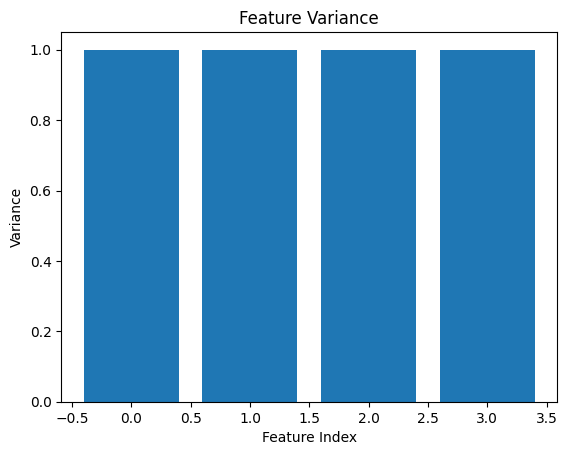

The most informative feature is at index: 0
(118, 1200)


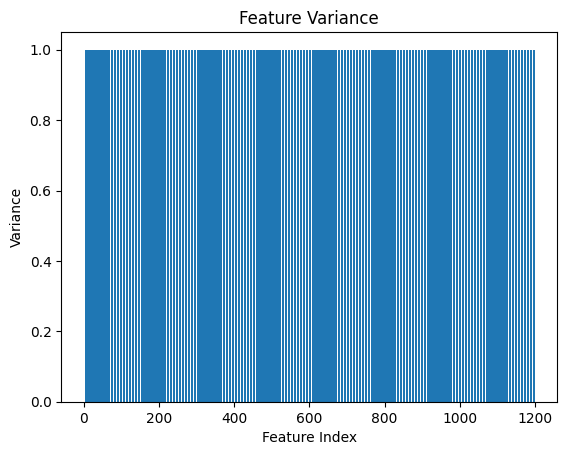

In [15]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Assuming you have your features stored in a 2D numpy array 'features'
# features.shape should be (num_samples, num_features)

# 1. Normalize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(amps_mags)

# 2. Calculate variance for each feature
normalized_features = normalized_features.reshape(-1, 4)
print(normalized_features.shape)

variances = np.var(normalized_features, axis=0)

# 3. Visualize the results
import matplotlib.pyplot as plt

plt.bar(range(len(variances)), variances)
plt.xlabel('Feature Index')
plt.ylabel('Variance')
plt.title('Feature Variance')
plt.show()

# 4. Select the most informative feature(s)
most_informative_feature_index = np.argmax(variances)
print(f"The most informative feature is at index: {most_informative_feature_index}")

# and also in the 1200 features of ampplitude where are we getting
# the most information from
amplitudes = np.array(amps).reshape(118, 1200)

# 1. Normalize the features
scaler = StandardScaler()
normalized_amplitudes = scaler.fit_transform(amplitudes)

# 2. Calculate variance for each feature
normalized_amplitudes = normalized_amplitudes.reshape(-1, 1200)
print(normalized_amplitudes.shape)

variances = np.var(normalized_amplitudes, axis=0)

# 3. Visualize the results
plt.bar(range(len(variances)), variances)
plt.xlabel('Feature Index')
plt.ylabel('Variance')
plt.title('Feature Variance')
plt.show()


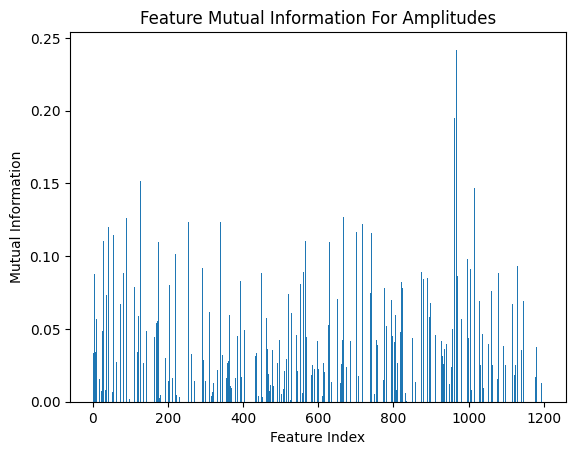

The most informative feature is at index: 968


In [16]:
from sklearn.feature_selection import mutual_info_classif

reshaped_features = np.array(amps).reshape(118, 1200)

# Calculate mutual information for each feature
mutual_information = mutual_info_classif(reshaped_features, extracted_labels)  # labels is your target variable

# Visualize the results
import matplotlib.pyplot as plt

plt.bar(range(len(mutual_information)), mutual_information)
plt.xlabel('Feature Index')
plt.ylabel('Mutual Information')
plt.title('Feature Mutual Information For Amplitudes')
plt.show()

# Select the most informative feature(s)
most_informative_feature_index = np.argmax(mutual_information)
print(f"The most informative feature is at index: {most_informative_feature_index}")


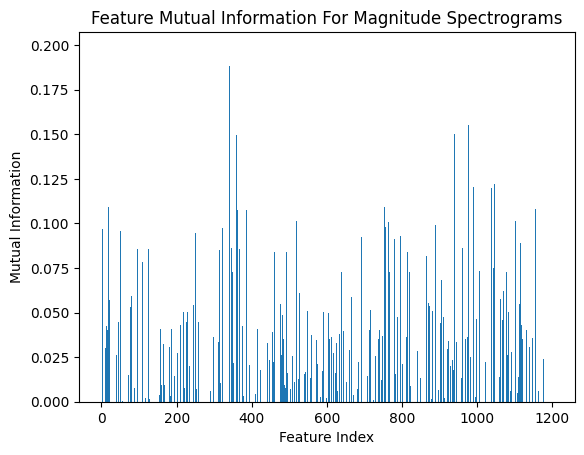

The most informative feature is at index: 1034


In [17]:
from sklearn.feature_selection import mutual_info_classif

reshaped_features = np.array(mags).reshape(118, 1200)

# Calculate mutual information for each feature
mutual_information = mutual_info_classif(reshaped_features, extracted_labels)  # labels is your target variable

# Visualize the results
import matplotlib.pyplot as plt

plt.bar(range(len(mutual_information)), mutual_information)
plt.xlabel('Feature Index')
plt.ylabel('Mutual Information')
plt.title('Feature Mutual Information For Magnitude Spectrograms')
plt.show()

# Select the most informative feature(s)
most_informative_feature_index = np.argmax(mutual_information)
print(f"The most informative feature is at index: {most_informative_feature_index}")

In [18]:
from sklearn.feature_selection import mutual_info_classif

reshaped_features = np.array(mfccs_new[0]).reshape(1, 1200)

# Calculate mutual information for each feature
mutual_information = mutual_info_classif(reshaped_features, extracted_labels[0])  # labels is your target variable

# Visualize the results
import matplotlib.pyplot as plt

plt.bar(range(len(mutual_information)), mutual_information)
plt.xlabel('Feature Index')
plt.ylabel('Mutual Information')
plt.title('Feature Mutual Information For MFCCs')
plt.show()

# Select the most informative feature(s)
most_informative_feature_index = np.argmax(mutual_information)
print(f"The most informative feature is at index: {most_informative_feature_index}")

ValueError: cannot reshape array of size 1 into shape (1,1200)

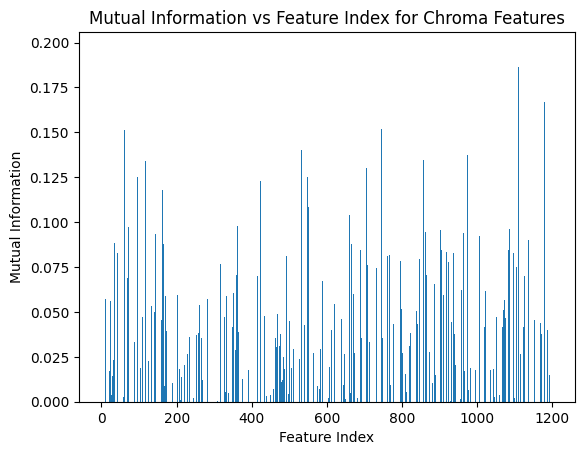

The most informative feature is at index: 350


In [ ]:
from sklearn.feature_selection import mutual_info_classif

reshaped_features = np.array(chromas_new[0]).reshape(1, 1200)

# Calculate mutual information for each feature
mutual_information = mutual_info_classif(reshaped_features, extracted_labels[0])  # labels is your target variable

# Visualize the results with a line plot
import matplotlib.pyplot as plt

feature_indices = range(len(mutual_information))

plt.bar(feature_indices, mutual_information)
plt.xlabel('Feature Index')
plt.ylabel('Mutual Information')
plt.title('Mutual Information vs Feature Index for Chroma Features')
plt.show()

# Select the most informative feature(s)
most_informative_feature_index = np.argmax(mutual_information)
print(f"The most informative feature is at index: {most_informative_feature_index}")